## Import libraries for initial data exploration

In [1]:
#This is an updated version

In [2]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd
import zipfile

import numpy as np;
import gzip;
from io import StringIO; 

## Read and visualize an input file

### Provide the root directory for where the user input files are, relative to the notebook location

In [3]:
root_dir = "ExtraSensory.per_uuid_features_labels/"

### File parser helper functions

In [4]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index(b'\n')];
    columns = headline.split(b',');

    # The first column should be timestamp:
    assert columns[0] == b'timestamp';
    
    # The last column should be label_source:
    assert columns[-1] == b'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith(b'label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith(b'label:');
        label_names[li] = label.replace(b'label:',b'');
        pass;
    
    return (feature_names, label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str.decode("utf-8")),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s%s.features_labels.csv.gz' % (root_dir, uuid);

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        pass;
    
    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

### Visualize contents of a single input file

In [5]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13'

In [6]:
(X, Y, M, timestamps, feature_names, label_names) = read_user_data(uuid);
feature_names = [i.decode("utf-8") for i in feature_names]
label_names = [i.decode("utf-8") for i in label_names]

for idx, feature in enumerate(feature_names):
    print(idx, " ", feature)

0   raw_acc:magnitude_stats:mean
1   raw_acc:magnitude_stats:std
2   raw_acc:magnitude_stats:moment3
3   raw_acc:magnitude_stats:moment4
4   raw_acc:magnitude_stats:percentile25
5   raw_acc:magnitude_stats:percentile50
6   raw_acc:magnitude_stats:percentile75
7   raw_acc:magnitude_stats:value_entropy
8   raw_acc:magnitude_stats:time_entropy
9   raw_acc:magnitude_spectrum:log_energy_band0
10   raw_acc:magnitude_spectrum:log_energy_band1
11   raw_acc:magnitude_spectrum:log_energy_band2
12   raw_acc:magnitude_spectrum:log_energy_band3
13   raw_acc:magnitude_spectrum:log_energy_band4
14   raw_acc:magnitude_spectrum:spectral_entropy
15   raw_acc:magnitude_autocorrelation:period
16   raw_acc:magnitude_autocorrelation:normalized_ac
17   raw_acc:3d:mean_x
18   raw_acc:3d:mean_y
19   raw_acc:3d:mean_z
20   raw_acc:3d:std_x
21   raw_acc:3d:std_y
22   raw_acc:3d:std_z
23   raw_acc:3d:ro_xy
24   raw_acc:3d:ro_xz
25   raw_acc:3d:ro_yz
26   proc_gyro:magnitude_stats:mean
27   proc_gyro:magnitude_sta

In [7]:
print(timestamps)
print(len(timestamps))

[1464129912 1464129950 1464130031 ... 1464887023 1464887322 1464887622]
2685


In [8]:
for idx, label in enumerate(label_names):
    print(idx, " ", label)

0   LYING_DOWN
1   SITTING
2   FIX_walking
3   FIX_running
4   BICYCLING
5   SLEEPING
6   LAB_WORK
7   IN_CLASS
8   IN_A_MEETING
9   LOC_main_workplace
10   OR_indoors
11   OR_outside
12   IN_A_CAR
13   ON_A_BUS
14   DRIVE_-_I_M_THE_DRIVER
15   DRIVE_-_I_M_A_PASSENGER
16   LOC_home
17   FIX_restaurant
18   PHONE_IN_POCKET
19   OR_exercise
20   COOKING
21   SHOPPING
22   STROLLING
23   DRINKING__ALCOHOL_
24   BATHING_-_SHOWER
25   CLEANING
26   DOING_LAUNDRY
27   WASHING_DISHES
28   WATCHING_TV
29   SURFING_THE_INTERNET
30   AT_A_PARTY
31   AT_A_BAR
32   LOC_beach
33   SINGING
34   TALKING
35   COMPUTER_WORK
36   EATING
37   TOILET
38   GROOMING
39   DRESSING
40   AT_THE_GYM
41   STAIRS_-_GOING_UP
42   STAIRS_-_GOING_DOWN
43   ELEVATOR
44   OR_standing
45   AT_SCHOOL
46   PHONE_IN_HAND
47   PHONE_IN_BAG
48   PHONE_ON_TABLE
49   WITH_CO-WORKERS
50   WITH_FRIENDS


In [9]:
Y.shape 

(2685, 51)

In [10]:
X.shape

(2685, 225)

### Visualize raw data

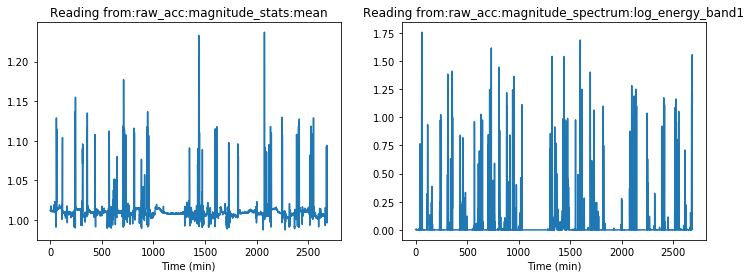

In [11]:
t = [i for i in range(len(X[:,0]))]
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,X[:,0])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[0])
plt.subplot(122)
plt.plot(t,X[:,10])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[10])
plt.show()

## Read and store all the file data

### Now that we've explored the dataset, we can store the rest of the files for processing.

In [12]:
from os import listdir
from os.path import isfile, join
import gzip
import shutil

In [13]:
onlyfiles = [f for f in listdir(root_dir)]
final_files = [] 
for i in onlyfiles: 
    x = '/%s%s' % (root_dir, i[0:len(i)-4]) 
    print(x)
    final_files.append(x)

/ExtraSensory.per_uuid_features_labels/00EABED2-271D-49D8-B599-1D4A09240601.features_labels
/ExtraSensory.per_uuid_features_labels/00EABED2-271D-49D8-B599-1D4A09240601.features_labels.cs
/ExtraSensory.per_uuid_features_labels/098A72A5-E3E5-4F54-A152-BBDA0DF7B694.features_labels
/ExtraSensory.per_uuid_features_labels/098A72A5-E3E5-4F54-A152-BBDA0DF7B694.features_labels.cs
/ExtraSensory.per_uuid_features_labels/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels
/ExtraSensory.per_uuid_features_labels/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.cs
/ExtraSensory.per_uuid_features_labels/0BFC35E2-4817-4865-BFA7-764742302A2D.features_labels
/ExtraSensory.per_uuid_features_labels/0BFC35E2-4817-4865-BFA7-764742302A2D.features_labels.cs
/ExtraSensory.per_uuid_features_labels/0E6184E1-90C0-48EE-B25A-F1ECB7B9714E.features_labels
/ExtraSensory.per_uuid_features_labels/0E6184E1-90C0-48EE-B25A-F1ECB7B9714E.features_labels.cs
/ExtraSensory.per_uuid_features_labels/1155FF54-63D3-4AB2-9863-83

In [14]:
# for idx in range(len(final_files)):
#     with gzip.open('.'+final_files[idx]+'.csv.gz', 'rb') as f_in:
#                 with open('.'+final_files[idx]+'.csv', 'wb') as f_out:
#                     shutil.copyfileobj(f_in, f_out)          

### Import Torch Libraries

In [15]:
import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import seaborn as sns 

### Visualize NaN entries in a sensor reading

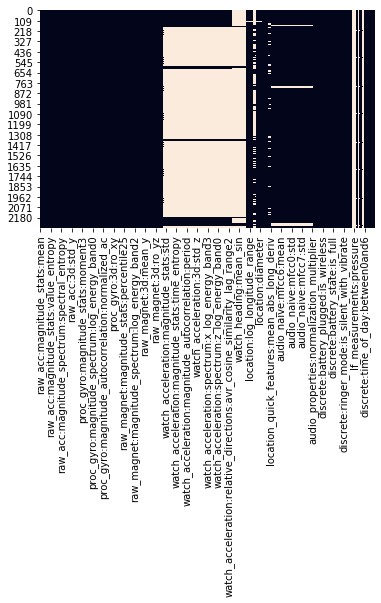

In [16]:
raw_d = pd.read_csv('.' + final_files[0] + '.csv')
sensor_data = raw_d.iloc[:,1:225]

heatmap = sns.heatmap(sensor_data.isnull(), cbar = False)

# for index, row in sensor_data.iterrows():
#     print(row.isnull())

In [17]:
labels_data = raw_d.iloc[:,226:-1]
labels_data.head()

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
1,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
2,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
3,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
4,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN


### Fill NaN with column mode, and drop remaining NaN

In [18]:
def remove_and_fill_nan(data):
    data[data.columns] = data[data.columns].fillna(data.mean().iloc[0])
    data.dropna(inplace = True, axis = 'columns' )
    return data
def remove_and_fill_nan_zero(data):
    data[data.columns] = data[data.columns].fillna(0)
    data.dropna(inplace = True, axis = 'columns' )
    return data

sensor_data = remove_and_fill_nan(sensor_data)
labels_data = remove_and_fill_nan_zero(labels_data)

In [19]:
labels_data.head()

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [20]:
labels_data.iloc[:10,:].to_numpy().shape

(10, 51)

### Visualize data before normalization

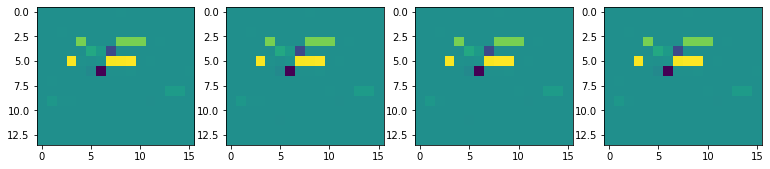

In [21]:
plt.figure(figsize = (13, 6))
plt.title('Unnormalizaed data')
for i in range(4): 
    ax = plt.subplot(1, 4, i+1)
    row_i = sensor_data.iloc[i,:].to_numpy().reshape(14, 16)
    ax.imshow(row_i)

### Normalize the data

In [22]:
def normalize_data(data):
    norm_data = pd.DataFrame() 
    for col in data.columns: 
        col_mean = data[col].mean()
        col_std = data[col].std()
        norm_data[col] = (data[col] - col_mean)/col_std
    
    norm_data.dropna(inplace = True, axis = 'columns' )
    return norm_data

norm_sensor_data = normalize_data(sensor_data)

#  Note the the number of columns has changed from the data set without normalization

### Visualize the data after normalization

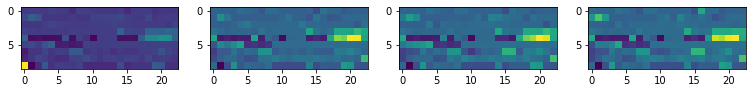

In [23]:
plt.figure(figsize = (13,6))
plt.title('Normalized data')
for i in range(4): 
    ax = plt.subplot(1,4,i+1)
    row_i = norm_sensor_data.iloc[i,:].to_numpy().reshape(9, 23)
    plt.imshow(row_i)

### Define helper functions for image manipulation

In [24]:
# Construct 2D image 
def reshape_img(tensor,w,h):
    return tensor.reshape([w,h])

# min-max normalization  
def min_max_norm(tensor, min_value, max_value):
    min_val = tensor.min()
    tensor = (tensor - min_val)
    max_val = tensor.max()
    tensor = tensor / max_val
    tensor = tensor * (max_val - min_val) + min_val
    return tensor 

### Create a SensorDataset class that can be used to store the data

In [25]:
class SensorDataset(Dataset): 
    
    def __init__(self, sensor_data, transform,labels_data):
        """provide directory with the user's data"""
        self.sensor_data = sensor_data
        self.transform = transform
        self.labels_data = labels_data
        
    def __len__(self):
        return len(self.sensor_data)
        
    # This function can be used to index into the dataset
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                 

        sample =  self.sensor_data.iloc[idx,:]
        labels =  self.labels_data.iloc[idx,:]
        
        if self.transform:
            # Transform to tensor
            sample = self.transform(sample.to_numpy().reshape(9, 23))
            
        return sample, torch.from_numpy(labels.to_numpy())

### Define the batch size parameter

In [26]:
batch_size = 20

### Create the training & test datasets

In [27]:
def create_train_test_sets(norm_data,labels=None):
    img_transform = transforms.Compose([
        transforms.ToTensor()])
    #     transforms.Lambda(lambda tensor:min_max_norm(tensor, 0, 1)),
    #     transforms.Lambda(lambda tensor:reshape_img(tensor,11,20))

    dataset_size = len(norm_data)

    # Indexes for 0 -> 2/3 of dataset_size
    row_train = [i for i in range(int(2*dataset_size/3))]
    train_data = norm_data.loc[row_train,:]

    # Indexes for 2/3 dataset_size -> end
    row_test = [i for i in range(int(2*dataset_size/3),dataset_size)] 
    test_data = norm_data.loc[row_test,:]
    
    print(len(train_data))
    print(len(test_data))

    train_data = SensorDataset(train_data, transform = img_transform,labels_data=labels.loc[row_train,:])
    test_data = SensorDataset(test_data, transform = img_transform,labels_data=labels.loc[row_test,:])
    
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True)
    
    return train_data, test_data, train_loader, test_loader


In [28]:
train_data, test_data, train_loader, test_loader = create_train_test_sets(norm_sensor_data, labels = labels_data)

1524
763


In [29]:
len(test_data)

763

In [30]:
dataset_size = len(norm_sensor_data)
row_test = [i for i in range(int(2*dataset_size/3),dataset_size)] 
norm_sensor_data.loc[row_test,:]

,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,lf_measurements:battery_level,lf_measurements:screen_brightness,lf_measurements:temperature_ambient,discrete:time_of_day:between0and6,discrete:time_of_day:between3and9,discrete:time_of_day:between6and12,discrete:time_of_day:between9and15,discrete:time_of_day:between12and18,discrete:time_of_day:between15and21,discrete:time_of_day:between18and24
1524,-0.355362,-0.278048,-0.216966,-0.296429,0.177301,-0.208804,-0.268429,0.428781,0.176902,0.173702,...,0.488872,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1525,-0.361438,-0.278130,-0.219168,-0.296444,0.176503,-0.218333,-0.270390,0.363605,0.176902,0.168159,...,0.488872,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1526,-0.366501,-0.277269,-0.226356,-0.296186,0.174167,-0.220879,-0.269525,0.786081,0.176902,0.182016,...,0.526032,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1527,-0.359222,-0.277918,-0.228741,-0.296589,0.176124,-0.209531,-0.268614,0.586479,0.176902,0.175219,...,0.526032,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1528,-0.367134,-0.277953,-0.225044,-0.296482,0.174627,-0.225462,-0.271162,0.545963,0.176902,0.164028,...,0.563193,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1529,-0.369222,-0.277588,-0.216647,-0.296072,0.172571,-0.223425,-0.271146,0.511735,0.176902,0.174852,...,0.563193,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1530,-0.368526,-0.278059,-0.216761,-0.296589,0.174347,-0.226553,-0.272459,0.550639,0.176902,0.181703,...,0.600353,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1531,-0.368906,-0.277022,-0.224725,-0.295737,0.173908,-0.226408,-0.270869,0.773117,0.176902,0.172865,...,0.600353,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1532,-0.379538,-0.277305,-0.226847,-0.295889,0.170175,-0.240156,-0.273277,0.581849,0.176902,0.174800,...,0.600353,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824
1533,-0.373779,-0.277375,-0.223664,-0.296269,0.171433,-0.232882,-0.271919,0.842957,0.176902,0.167270,...,0.637514,-0.743819,-0.999781,-0.451917,-0.505758,-0.510525,-0.47834,-0.582777,-0.751744,1.304824


## Visualize the training data as images

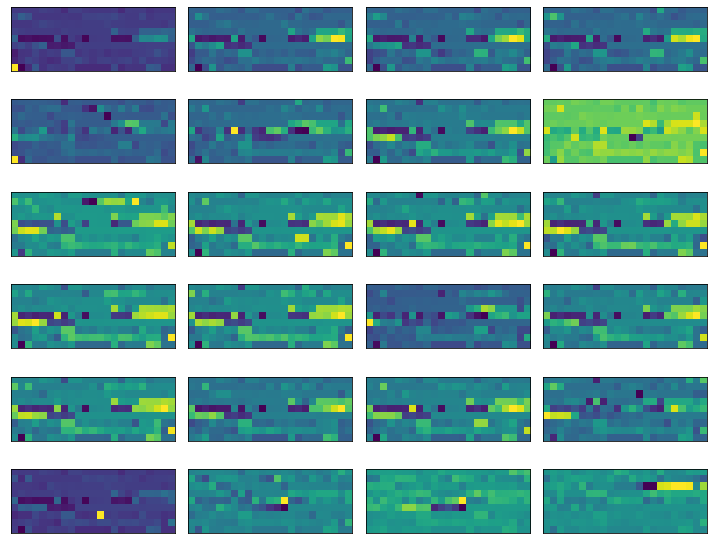

In [31]:
fig = plt.figure(figsize=(10, 8))
count = 0 
for i in range(24):
    ax = plt.subplot(6,4,count+1)
    
    im = train_data[count][0]
    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.imshow(im.numpy().squeeze())
    count +=1
    
fig.tight_layout(pad=1.0)

## Process the data with an Autoencoder

### Initialize the Autoencoder variables and hyperparameters

In [32]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Create Autoencoder class

In [33]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"],out_features=100),
            nn.ReLU(True),
            nn.Linear(100, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 100),
            nn.ReLU(True),
            nn.Linear(in_features= 100, out_features=kwargs["input_shape"]))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def forward_encoder_only(self,x):
        return self.encoder(x)

In [34]:
# class Autoencoder_EncodeOnly(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=kwargs["input_shape"],out_features=100),
#             nn.ReLU(True),
#             nn.Linear(100, 64),
#             nn.ReLU(True))
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 100),
#             nn.ReLU(True),
#             nn.Linear(in_features= 100, out_features=kwargs["input_shape"]))

#     def forward(self, x):
#         x = self.encoder(x)
#         return x

### Leverage GPU, if available

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define the input shape

In [36]:
input_shape = 207
input_shape_s1 = 9
input_shape_s2 = 23

### Create an autoencoder instance

In [37]:
model = Autoencoder(input_shape = input_shape).to(device)

## Train the autoencoder

### Define the `fit()` method

In [38]:
def fit(current_epoch):
    model.train()
    
    # Reset local variables
    loss = 0
    count = 0

    # Iterate through the training dataset
    for batch_features,_ in train_loader:

        # Reshape mini-batch data to [N, input_shape] matrix
        batch_features = batch_features.view(-1, input_shape).to(device)

        # Reset the gradients back to zero
        optimizer.zero_grad()

        # Compute reconstructions
        outputs = model(batch_features.float())

        # Compute training reconstruction loss
        train_loss = criterion(outputs, batch_features.float())

        # Compute accumulated gradients
        train_loss.backward()

        # Perform parameter update based on current gradients
        optimizer.step()

        # Add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # Compute the average training loss across the epoch
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(current_epoch + 1, num_epochs, loss)) 
    
    # Return the loss for this iteration
    return loss

### Define a validate function

In [39]:
def validate(current_epoch):
    model.eval()
    batch_count = 0
    
    # Reset local variables
    loss = 0 
    count = 0
    is_first_loss = True
    
    loader_len = len(test_loader)
    turn_point = int(loader_len/batch_size) * batch_size + loader_len % batch_size -1
    
    # Iterate through the test dataset (we are using this data for validation, too)
    for cnt, batch in enumerate(test_loader): 
        
        batch_count += 1

        # Reshape mini-batch data to [N, input_shape] matrix
        batch_features, y_obs = batch
        batch_features = batch_features.view(-1, input_shape).to(device)
        
        # Use the model
        y_pred = model(batch_features.float())
        
        # Test loss
        y_pred = y_pred.squeeze()
        y_obs = y_obs.squeeze()
        val_loss = criterion(y_pred, batch_features.float())

        # Add the mini-batch training loss to epoch loss
        loss += val_loss.item()

    # Compute the average training loss across the epoch
    loss = loss / loader_len
    print('VALIDATE:','\t Epoch:', current_epoch,'\t Loss:',loss/batch_count)
    
    # Return the loss for this iteration
    return loss

### Run the fit and validation functions

In [40]:
# Define parameters for autoencoder
num_epochs = 20
learn_rate = 1e-3
train_loss_array = []
validate_loss_array = []
optimizer = optim.Adam(model.parameters(), lr = learn_rate)
criterion = nn.MSELoss()

min_val_loss = 100000000
min_val_epoch = 1

# Iterate through all epochs
for current_epoch in range(num_epochs):
    
    # Train & validate for the current epoch
    train_loss_array.append(fit(current_epoch))
    validate_loss_array.append(validate(current_epoch))
    
    if validate_loss_array[-1] < min_val_loss:
        min_val_loss =  validate_loss_array[-1]
        min_val_epoch = current_epoch

epoch : 1/20, loss = 0.890593
VALIDATE: 	 Epoch: 0 	 Loss: 0.024561367424438846
epoch : 2/20, loss = 0.684341
VALIDATE: 	 Epoch: 1 	 Loss: 0.022287331624379052
epoch : 3/20, loss = 0.581664
VALIDATE: 	 Epoch: 2 	 Loss: 0.021262698487809113
epoch : 4/20, loss = 0.508968
VALIDATE: 	 Epoch: 3 	 Loss: 0.019582369917713442
epoch : 5/20, loss = 0.473936
VALIDATE: 	 Epoch: 4 	 Loss: 0.018656176360009297
epoch : 6/20, loss = 0.442537
VALIDATE: 	 Epoch: 5 	 Loss: 0.01878167681988723
epoch : 7/20, loss = 0.425459
VALIDATE: 	 Epoch: 6 	 Loss: 0.018133085899490968
epoch : 8/20, loss = 0.404663
VALIDATE: 	 Epoch: 7 	 Loss: 0.018006672794923902
epoch : 9/20, loss = 0.388893
VALIDATE: 	 Epoch: 8 	 Loss: 0.01886417019688558
epoch : 10/20, loss = 0.377313
VALIDATE: 	 Epoch: 9 	 Loss: 0.01739167082591875
epoch : 11/20, loss = 0.368659
VALIDATE: 	 Epoch: 10 	 Loss: 0.01795786057821157
epoch : 12/20, loss = 0.357551
VALIDATE: 	 Epoch: 11 	 Loss: 0.017454395309472695
epoch : 13/20, loss = 0.347601
VALIDATE

In [41]:
loss_results = train_loss_array

### Visualize how loss changes with # of epochs for training data 

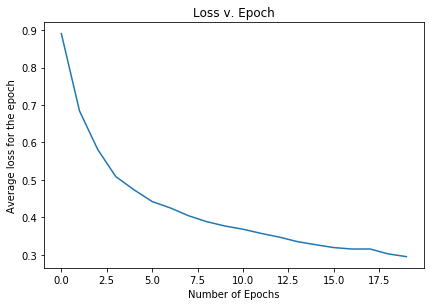

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.tight_layout()
ax1.plot(loss_results)
plt.xlabel("Number of Epochs")
plt.ylabel("Average loss for the epoch")
plt.title("Loss v. Epoch")
plt.show()

## Test the dataset

In [43]:
test_examples = None
reconstruction = None

with torch.no_grad():
    for batch_features,_ in test_loader:
        test_examples = batch_features.view(-1, input_shape)
        reconstruction = model(test_examples.float())
        break

### Visualize the results

In [44]:
print(test_examples.shape)
print(reconstruction.shape)

torch.Size([20, 207])
torch.Size([20, 207])


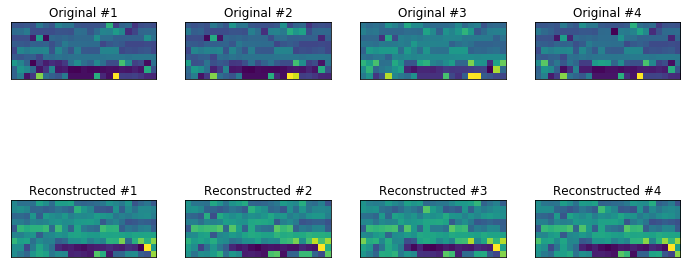

In [45]:
with torch.no_grad():
    number = 4
    plt.figure(figsize=(12, 6))
    for index in range(number):
        
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(input_shape_s1, input_shape_s2))
        plt.title('Original #' + str(index + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstructed
        ax = plt.subplot(2, number, index + 1+ number)
        plt.imshow(reconstruction[index].numpy().reshape(input_shape_s1, input_shape_s2))
        plt.title('Reconstructed #' + str(index + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

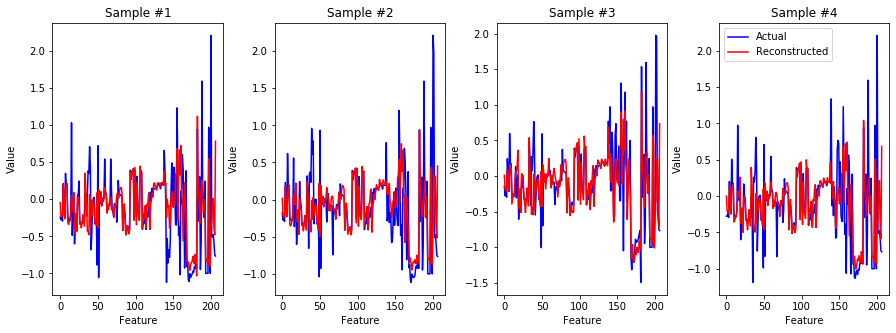

In [46]:
t = [i for i in range(input_shape)]
count = 0 
with torch.no_grad():
    number = 4
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    for index in range(number):
        # display original
        ax = plt.subplot(1, number, index + 1)
        sensor_read = test_examples[index].numpy().reshape(input_shape, 1)
        plt.title('Sample #' + str(index + 1))
        plt.xlabel('Feature')
        plt.ylabel('Value')
        plt.subplot(ax)
        plt.plot(t, sensor_read, color = 'b', label = 'Actual')

        sensor_read_rec = reconstruction[index].numpy().reshape(input_shape, 1)
        plt.plot(t, sensor_read_rec, color = 'r', label = 'Reconstructed'); 

plt.legend(loc ='best')
plt.show() 

# Run the Autoencoder logic for all the files

In [39]:
encoded_vals = [j for j in range(len(final_files))]
count = 0
labels_shape = 226
for file in final_files:
    if (file.endswith('.cs')):
        continue
       
    raw_d = pd.read_csv('.' + file + '.csv')
    
    sensor_data = raw_d.iloc[:,1:input_shape+1]
    sensor_data = remove_and_fill_nan(sensor_data)
    labels_data = raw_d.iloc[:,labels_shape:-1]
    labels_data = remove_and_fill_nan_zero(labels_data)
    norm_sensor_data = normalize_data(sensor_data)
    train_data_set, test_data_set, train_dataset_loader, test_dataset_loader = create_train_test_sets(norm_sensor_data,labels_data)
    
    # Use the Autoencoder that only encodes
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder_EncodeOnly(input_shape = input_shape).to(device)
    
    # Use the Autoencoder that both encodes and decodes
    # model = Autoencoder(input_shape = input_shape).to(device)
    
    # loss_results = fit(num_epochs = 20, learn_rate = 1e-3)
    
    i = 0
    reconstruction = [[] for i in range(len(test_dataset_loader))]
    with torch.no_grad():
        for batch_features in test_dataset_loader:
            test_examples = batch_features.view(-1, input_shape)
            reconstruction[i] = model(test_examples.float())
            break
    
    encoded_vals[count] = model(test_examples.float())
    count += 1

print(encoded_vals[0])

tensor([[0.2526, 0.0000, 0.0000,  ..., 0.0000, 0.1187, 0.0000],
        [0.3936, 0.0000, 0.1353,  ..., 0.0000, 0.1110, 0.0000],
        [0.2099, 0.0000, 0.0226,  ..., 0.0786, 0.0000, 0.0000],
        ...,
        [0.1438, 0.0000, 0.0000,  ..., 0.0000, 0.1134, 0.0000],
        [0.3498, 0.0000, 0.0000,  ..., 0.5206, 1.2192, 0.7647],
        [0.2082, 0.0000, 0.0000,  ..., 0.0632, 0.1259, 0.0031]],
       grad_fn=<ReluBackward1>)
